#Location Based Restaurant Recommendation System

Lets create a SparkSession with the application name "Location based Restaurant Recommendation System"

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.appName("Location based Restaurant Recommendation System").getOrCreate()

## Data Loading

We will define a schema for the Yelp business dataset and apply it to read the data from the JSON file

In [0]:
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, DoubleType, BooleanType, IntegerType
# Define the schema for the business dataframe
schema = StructType([
    StructField("business_id", StringType(), nullable=True),
    StructField("name", StringType(), nullable=True),
    StructField("address", StringType(), nullable=True),
    StructField("city", StringType(), nullable=True),
    StructField("state", StringType(), nullable=True),
    StructField("latitude", DoubleType(), nullable=True),
    StructField("longitude", DoubleType(), nullable=True),
    StructField("stars", DoubleType(), nullable=True),
    StructField("review_count", IntegerType(), nullable=True),
    StructField("is_open", IntegerType(), nullable=True),
    StructField("attributes", StringType(), nullable=True),
    StructField("categories", StringType(), nullable=True),
    StructField("hours", StringType(), nullable=True),
])

# Apply the defined schema to the business dataframe 
business_df= spark.read.format("json").schema(schema).option("header", True).load("dbfs:/FileStore/tables/yelp_academic_dataset_business.json")


Lets see if the data is properly stored or not

In [0]:
business_df.show(5)

+--------------------+--------------------+--------------------+-------------+-----+----------+------------+-----+------------+-------+--------------------+--------------------+--------------------+
|         business_id|                name|             address|         city|state|  latitude|   longitude|stars|review_count|is_open|          attributes|          categories|               hours|
+--------------------+--------------------+--------------------+-------------+-----+----------+------------+-----+------------+-------+--------------------+--------------------+--------------------+
|Pns2l4eNsfO8kk83d...|Abby Rappoport, L...|1616 Chapala St, ...|Santa Barbara|   CA|34.4266787|-119.7111968|  5.0|           7|      0|{"ByAppointmentOn...|Doctors, Traditio...|                null|
|mpf3x-BjTdTEA3yCZ...|       The UPS Store|87 Grasso Plaza S...|       Affton|   MO| 38.551126|  -90.335695|  3.0|          15|      1|{"BusinessAccepts...|Shipping Centers,...|{"Monday":"0:0-0:...|
|tUFr

Lets rename the "name" column in the business_df DataFrame to "Restaurant Name".

In [0]:
business_df = business_df.withColumnRenamed("name", "Restaurant Name")

##Data Cleaning

Let us first check the number of missing values in business dataframe.

In [0]:
from pyspark.sql.functions import sum, isnull

# Count the number of missing values in each column
missing_count = business_df.select([sum(isnull(c).cast("int")).alias(c) for c in business_df.columns])

# Show the results
missing_count.show()

+-----------+---------------+-------+----+-----+--------+---------+-----+------------+-------+----------+----------+-----+
|business_id|Restaurant Name|address|city|state|latitude|longitude|stars|review_count|is_open|attributes|categories|hours|
+-----------+---------------+-------+----+-----+--------+---------+-----+------------+-------+----------+----------+-----+
|          0|              0|      0|   0|    0|       0|        0|    0|           0|      0|     13744|       103|23223|
+-----------+---------------+-------+----+-----+--------+---------+-----+------------+-------+----------+----------+-----+



We can see that attributes column has 13744, categories has 103 and hours has 23222 null values. Removing the rows with missing data can result in loss of data, especially hours column has a large number of missing values. Although the columns like attributes and hours are not as significant compared to the categories column. It may be best to keep the rows with Categories address values as unknown.

In [0]:
# Drop columns
business_df = business_df.drop("attributes", "hours")

# Fill null values in Categories column with "unknown"
business_df = business_df.na.fill({"categories": "unknown"})

Lets see if the columns are dropped from the dataframe.

In [0]:
business_df.columns

Out[7]: ['business_id',
 'Restaurant Name',
 'address',
 'city',
 'state',
 'latitude',
 'longitude',
 'stars',
 'review_count',
 'is_open',
 'categories']

We will check if there are any missing values to confirm that all missing values have been taken care of.

In [0]:
# Count the number of missing values in each column
missing_count = business_df.select([sum(isnull(c).cast("int")).alias(c) for c in business_df.columns])

# Show the results
missing_count.show()

+-----------+---------------+-------+----+-----+--------+---------+-----+------------+-------+----------+
|business_id|Restaurant Name|address|city|state|latitude|longitude|stars|review_count|is_open|categories|
+-----------+---------------+-------+----+-----+--------+---------+-----+------------+-------+----------+
|          0|              0|      0|   0|    0|       0|        0|    0|           0|      0|         0|
+-----------+---------------+-------+----+-----+--------+---------+-----+------------+-------+----------+



In [0]:
business_df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- Restaurant Name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- is_open: integer (nullable = true)
 |-- categories: string (nullable = false)



In [0]:
business_df.show(truncate=False)

+----------------------+------------------------+------------------------------------------+--------------+-----+-------------+--------------+-----+------------+-------+----------------------------------------------------------------------------------------------------------+
|business_id           |Restaurant Name         |address                                   |city          |state|latitude     |longitude     |stars|review_count|is_open|categories                                                                                                |
+----------------------+------------------------+------------------------------------------+--------------+-----+-------------+--------------+-----+------------+-------+----------------------------------------------------------------------------------------------------------+
|Pns2l4eNsfO8kk83dixA6A|Abby Rappoport, LAC, CMQ|1616 Chapala St, Ste 2                    |Santa Barbara |CA   |34.4266787   |-119.7111968  |5.0  |7           |0      |

##Exploratory Data Analysis

Lets filter the restaurants from the business dataframe 'business_df' which has restaurant as one of its values in categories column and store it into a new dataframe called restaurant_df.

In [0]:
from pyspark.sql.functions import col

# Filter rows that contain the substring 'Restaurants' in the categories column
restaurant_df = business_df.filter(col('categories').like('%Restaurants%'))

# Show the first few rows of the new DataFrame
restaurant_df.show(5)

+--------------------+--------------------+-------------------+------------+-----+----------+-----------+-----+------------+-------+--------------------+
|         business_id|     Restaurant Name|            address|        city|state|  latitude|  longitude|stars|review_count|is_open|          categories|
+--------------------+--------------------+-------------------+------------+-----+----------+-----------+-----+------------+-------+--------------------+
|MTSW4McQd7CbVtyjq...|  St Honore Pastries|        935 Race St|Philadelphia|   PA|39.9555052|-75.1555641|  4.0|          80|      1|Restaurants, Food...|
|CF33F8-E6oudUQ46H...|      Sonic Drive-In|      615 S Main St|Ashland City|   TN| 36.269593| -87.058943|  2.0|           6|      1|Burgers, Fast Foo...|
|k0hlBqXX-Bt0vf1op...|Tsevi's Pub And G...|  8025 Mackenzie Rd|      Affton|   MO|38.5651648|-90.3210868|  3.0|          19|      0|Pubs, Restaurants...|
|bBDDEgkFA1Otx9Lfe...|      Sonic Drive-In|2312 Dickerson Pike|   Nashville|

Lets check the top 20 restaurants.

In [0]:
from pyspark.sql.functions import desc

top_restaurants = restaurant_df.orderBy(desc("review_count"), desc("stars")).limit(20)
top_restaurants.show()

+--------------------+--------------------+--------------------+-------------+-----+-------------+--------------+-----+------------+-------+--------------------+
|         business_id|     Restaurant Name|             address|         city|state|     latitude|     longitude|stars|review_count|is_open|          categories|
+--------------------+--------------------+--------------------+-------------+-----+-------------+--------------+-----+------------+-------+--------------------+
|_ab50qdWOk0DdB6XO...|   Acme Oyster House|    724 Iberville St|  New Orleans|   LA|   29.9542735|   -90.0689651|  4.0|        7568|      1|Live/Raw Food, Se...|
|ac1AeYqs8Z4_e2X5M...|        Oceana Grill|        739 Conti St|  New Orleans|   LA|    29.956231|    -90.067563|  4.0|        7400|      1|Restaurants, Seaf...|
|GXFMD0Z4jEVZBCsbP...|Hattie B’s Hot Ch...|      112 19th Ave S|    Nashville|   TN|36.1513871523|-86.7966029393|  4.5|        6093|      1|American (Traditi...|
|ytynqOUb3hjKeJfRj...|Readin

In [0]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

top_restaurants = restaurant_df.orderBy(F.desc("review_count"), F.desc("stars")).limit(20)

display(top_restaurants.select("Restaurant Name", "stars"))

Restaurant Name stars Acme Oyster House 4.0 Oceana Grill 4.0 Hattie B’s Hot Chicken - Nashville 4.5 Reading Terminal Market 4.5 Ruby Slipper - New Orleans 4.5 Mother's Restaurant 3.5 Royal House 4.0 Commander's Palace 4.5 Luke 4.0 Cochon 4.0 Pat's King of Steaks 3.0 Biscuit Love: Gulch 4.0 Pappy's Smokehouse 4.5 Felix's Restaurant & Oyster Bar 4.0 Gumbo Shop 4.0 Cochon Butcher 4.5 Los Agaves 4.5 Willie Mae's Scotch House 4.5 Geno's Steaks 2.5 Datz 4.0

Let's view the spatial distribution of all the restaurants on a map.

In [0]:
import folium
from pyspark.sql.functions import first

# Get the first row of the DataFrame to center the map
first_row = restaurant_df.select(first('latitude'), first('longitude')).first()

# Create a map centered on the latitude and longitude of the first restaurant in the DataFrame
m = folium.Map(location=[first_row['first(latitude)'], first_row['first(longitude)']], zoom_start=10)

# Iterate over the rows in the DataFrame and add markers to the map
for row in restaurant_df.collect():
    folium.Marker(location=[row['latitude'], row['longitude']], 
                  popup=f"{row['Restaurant Name']} ({row['stars']} stars)").add_to(m)

# Save the map to an HTML file
m.save('restaurant_map.html')

The above code cannot display the map for me here as the command result size exceeds limit: Exceeded 20971520 bytes (current = 20974428). So I have to save it into a html to view it separately. However, I just want to check if it is displaying properly or not. So, I converted the Spark dataframe into a Pandas dataframe.

In [0]:
import pandas as pd

# Convert PySpark DataFrame to pandas DataFrame
rest_df = restaurant_df.toPandas()

rest_df.head(10)

business_id 
 Restaurant Name 
 address 
 city 
 state 
 latitude 
 longitude 
 stars 
 review_count 
 is_open 
 categories 
 
 
 
 
 0 
 MTSW4McQd7CbVtyjqoe9mw 
 St Honore Pastries 
 935 Race St 
 Philadelphia 
 PA 
 39.955505 
 -75.155564 
 4.0 
 80 
 1 
 Restaurants, Food, Bubble Tea, Coffee & Tea, B... 
 
 
 1 
 CF33F8-E6oudUQ46HnavjQ 
 Sonic Drive-In 
 615 S Main St 
 Ashland City 
 TN 
 36.269593 
 -87.058943 
 2.0 
 6 
 1 
 Burgers, Fast Food, Sandwiches, Food, Ice Crea... 
 
 
 2 
 k0hlBqXX-Bt0vf1op7Jr1w 
 Tsevi's Pub And Grill 
 8025 Mackenzie Rd 
 Affton 
 MO 
 38.565165 
 -90.321087 
 3.0 
 19 
 0 
 Pubs, Restaurants, Italian, Bars, American (Tr... 
 
 
 3 
 bBDDEgkFA1Otx9Lfe7BZUQ 
 Sonic Drive-In 
 2312 Dickerson Pike 
 Nashville 
 TN 
 36.208102 
 -86.768170 
 1.5 
 10 
 1 
 Ice Cream & Frozen Yogurt, Fast Food, Burgers,... 
 
 
 4 
 eEOYSgkmpB90uNA7lDOMRA 
 Vietnamese Food Truck 
 
 Tampa Bay 
 FL 
 27.955269 
 -82.456320 
 4.0 
 10 
 1 
 Vietnamese, Food, Restaurants, Food Trucks 
 
 
 5 
 il_Ro8jwPlHresjw9EGmBg 
 Denny's 
 8901 US 31 S 
 Indianapolis 
 IN 
 39.637133 
 -86.127217 
 2.5 
 28 
 1 
 American (Traditional), Restaurants, Diners, B... 
 
 
 6 
 0bPLkL0QhhPO5kt1_EXmNQ 
 Zio's Italian Market 
 2575 E Bay Dr 
 Largo 
 FL 
 27.916116 
 -82.760461 
 4.5 
 100 
 0 
 Food, Delis, Italian, Bakeries, Restaurants 
 
 
 7 
 MUTTqe8uqyMdBl186RmNeA 
 Tuna Bar 
 205 Race St 
 Philadelphia 
 PA 
 39.953949 
 -75.143226 
 4.0 
 245 
 1 
 Sushi Bars, Restaurants, Japanese 
 
 
 8 
 ROeacJQwBeh05Rqg7F6TCg 
 BAP 
 1224 South St 
 Philadelphia 
 PA 
 39.943223 
 -75.162568 
 4.5 
 205 
 1 
 Korean, Restaurants 
 
 
 9 
 WKMJwqnfZKsAae75RMP6jA 
 Roast Coffeehouse and Wine Bar 
 10359 104 Street NW 
 Edmonton 
 AB 
 53.546045 
 -113.499169 
 4.0 
 40 
 0 
 Coffee & Tea, Food, Cafes, Bars, Wine Bars, Re...

Viewing the top 20 restaurants on a graph with their ratings.

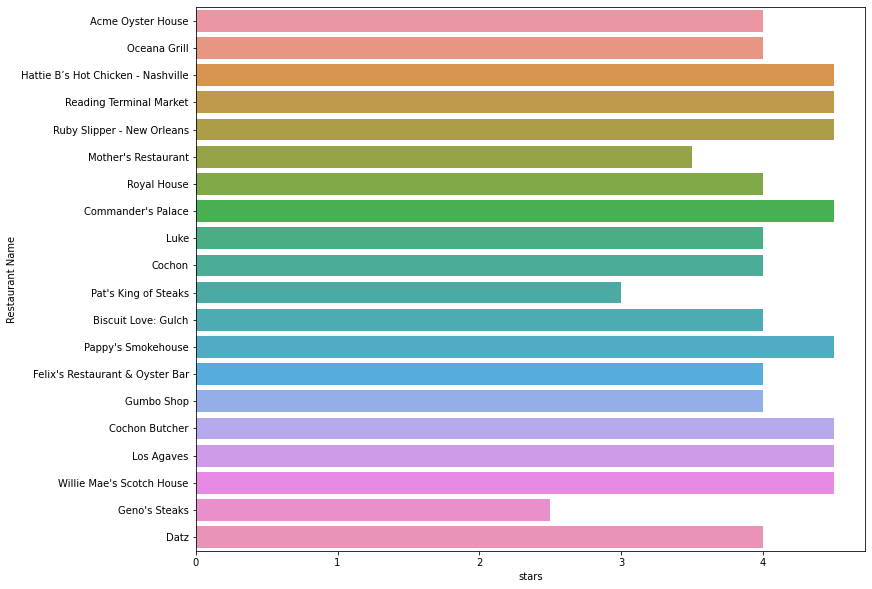

In [0]:
import seaborn as sns
top_restaurants = rest_df.sort_values(by=['review_count', 'stars'], ascending=False)[:20]
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(x = 'stars', y = 'Restaurant Name', data=top_restaurants, ax= ax);
plt.show()

In [0]:
import plotly_express as px

px.set_mapbox_access_token("pk.eyJ1Ijoic2lkZHAyNzQiLCJhIjoiY2txZHM2bjdyMDd6bjJvbWxkcG5odW5zNCJ9.SZll1uNjsTQ-IdGd1n7zCw")
#configure_plotly_browser_state()
px.scatter_mapbox(rest_df, lat="latitude", lon="longitude", color="stars", size='review_count' ,size_max=30, zoom=3, width=1200, height=800)

Lets just take a city and view its restaurants in a spatial distribution.

In [0]:
Philly = rest_df[rest_df.state == 'PA']
px.scatter_mapbox(Philly, lat="latitude", lon="longitude", color="stars", size='review_count' , size_max=15, zoom=10, width=1200, height=800)

##K-Means Clustering

In [0]:
# Import the required libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import calinski_harabasz_score

In [0]:
# select the relevant columns
res_df = rest_df[['Restaurant Name', 'address', 'city', 'state', 'latitude', 'longitude', 'stars', 'review_count']]


Let's group the restaurants based on the city in order to divide them into clusters.

In [0]:
# group by city
grouped_df = res_df.groupby('city').mean()

# reset index to turn city into a column
grouped_df = grouped_df.reset_index()

# print the first 5 rows
grouped_df

city 
 latitude 
 longitude 
 stars 
 review_count 
 
 
 
 
 0 
 Abington 
 40.124355 
 -75.120116 
 3.425926 
 59.296296 
 
 
 1 
 Abington Township 
 40.088570 
 -75.092642 
 4.000000 
 223.000000 
 
 
 2 
 Affton 
 38.547055 
 -90.320202 
 3.472222 
 37.666667 
 
 
 3 
 Aldan 
 39.924644 
 -75.282594 
 4.000000 
 24.333333 
 
 
 4 
 Algiers 
 29.931748 
 -90.003541 
 1.500000 
 28.000000 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 915 
 sewell 
 39.804543 
 -75.094650 
 4.000000 
 28.000000 
 
 
 916 
 spring city 
 40.178927 
 -75.546980 
 4.000000 
 6.000000 
 
 
 917 
 tucson 
 32.211795 
 -110.968896 
 3.500000 
 155.000000 
 
 
 918 
 wilmington 
 39.737432 
 -75.554725 
 4.000000 
 61.000000 
 
 
 919 
 wimauma 
 27.712212 
 -82.298825 
 4.500000 
 8.000000 
 
 
 
 920 rows × 5 columns

Let's determine the optimal k value for our model using the Elbow method.

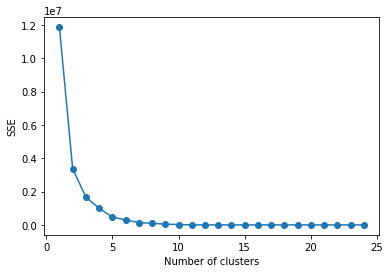

In [0]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# create an empty list to store the SSE values for each k
sse = []

# fit KMeans clustering with different k values (from 1 to 10)
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(res_df[['latitude', 'longitude']])
    sse.append(kmeans.inertia_)

# plot the SSE values against k
plt.plot(range(1, 25), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

Based on the elbow method curve, the optimal k value can be chosen as the point where the change in distortion (SSE) starts to level off. In the plot, the elbow point appears to be around k=4 or k=5. However, it's important to keep in mind that the choice of k can also depend on the specific problem domain and the objective of the clustering analysis.

So, choosing k=5 as the optimal value seems reasonable based on the elbow method plot.

In [0]:
# Import the KMeans module
from sklearn.cluster import KMeans

# Set the value of k to 5
k = 5

# Create a KMeans object with k clusters
kmeans = KMeans(n_clusters=k, random_state=42)

# Fit the KMeans model to the data
kmeans.fit(grouped_df[['latitude', 'longitude']])

# Get the cluster labels
labels = kmeans.labels_

# Add a new column to the grouped_df DataFrame with the cluster labels
grouped_df['cluster'] = labels

grouped_df.head()

city 
 latitude 
 longitude 
 stars 
 review_count 
 cluster 
 
 
 
 
 0 
 Abington 
 40.124355 
 -75.120116 
 3.425926 
 59.296296 
 0 
 
 
 1 
 Abington Township 
 40.088570 
 -75.092642 
 4.000000 
 223.000000 
 0 
 
 
 2 
 Affton 
 38.547055 
 -90.320202 
 3.472222 
 37.666667 
 1 
 
 
 3 
 Aldan 
 39.924644 
 -75.282594 
 4.000000 
 24.333333 
 0 
 
 
 4 
 Algiers 
 29.931748 
 -90.003541 
 1.500000 
 28.000000 
 3

Let's  visualize the clusters on a map to see their spatial distribution.

In [0]:
import plotly.express as px

# create a scatter mapbox plot with color-coded clusters
fig = px.scatter_mapbox(
    data_frame=grouped_df,
    lat="latitude",
    lon="longitude",
    color="cluster",
    zoom=5,
    hover_name="cluster",
    hover_data=["stars", "review_count"]
)

# add mapbox style
fig.update_layout(mapbox_style="open-street-map")

# show the plot
fig.show()

Lets create a dictionary that maps each city to its corresponding cluster. This way, the user can input the name of the city and we can retrieve its corresponding cluster number from the dictionary.

In [0]:
city_to_cluster = {}

# Loop through each city in the grouped dataframe and retrieve its cluster number
for city_name, group in grouped_df.groupby('city'):
    city_to_cluster[city_name] = int(group.iloc[0]['cluster'])

Let's create a new column called cluster in res_df to assign the corresponding cluster value to it based on the city it is located in.

In [0]:
res_df['cluster'] = res_df['city'].apply(lambda x: city_to_cluster.get(x, -1))
res_df

<command-3931370796390135>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Restaurant Name 
 address 
 city 
 state 
 latitude 
 longitude 
 stars 
 review_count 
 cluster 
 
 
 
 
 0 
 St Honore Pastries 
 935 Race St 
 Philadelphia 
 PA 
 39.955505 
 -75.155564 
 4.0 
 80 
 0 
 
 
 1 
 Sonic Drive-In 
 615 S Main St 
 Ashland City 
 TN 
 36.269593 
 -87.058943 
 2.0 
 6 
 1 
 
 
 2 
 Tsevi's Pub And Grill 
 8025 Mackenzie Rd 
 Affton 
 MO 
 38.565165 
 -90.321087 
 3.0 
 19 
 1 
 
 
 3 
 Sonic Drive-In 
 2312 Dickerson Pike 
 Nashville 
 TN 
 36.208102 
 -86.768170 
 1.5 
 10 
 1 
 
 
 4 
 Vietnamese Food Truck 
 
 Tampa Bay 
 FL 
 27.955269 
 -82.456320 
 4.0 
 10 
 3 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 52263 
 Wawa 
 19 N Bishop Ave 
 Clifton Heights 
 PA 
 39.925656 
 -75.310344 
 3.0 
 11 
 0 
 
 
 52264 
 Dutch Bros Coffee 
 1181 N Milwaukee St 
 Boise 
 ID 
 43.615401 
 -116.284689 
 4.0 
 33 
 2 
 
 
 52265 
 Adelita Taqueria & Restaurant 
 1108 S 9th St 
 Philadelphia 
 PA 
 39.935982 
 -75.158665 
 4.5 
 35 
 0 
 
 
 52266 
 The Plum Pit 
 4405 Pennell Rd 
 Aston 
 DE 
 39.856185 
 -75.427725 
 4.5 
 14 
 0 
 
 
 52267 
 West Side Kebab House 
 2470 Guardian Road NW 
 Edmonton 
 AB 
 53.509649 
 -113.675999 
 4.5 
 18 
 4 
 
 
 
 52268 rows × 9 columns

Now, To do a location-based recommendation, we can take the following steps:

1. Get the user's location (latitude and longitude).
2. Find the cluster number of the user's location using the k-means model.
3. Filter the restaurants in the same cluster as the user's location.
4. Sort the filtered restaurants by their rating or review count.
5. Recommend the top-rated or most reviewed restaurants to the user.

In [0]:
from geopy.geocoders import Nominatim
#geolocator = Nominatim(user_agent="my_script")

geolocator = Nominatim(user_agent="my_script")
location = geolocator.geocode("Nashville")
print(location.latitude, location.longitude)

36.1622767 -86.7742984


#Location based Restaurant Recommender

Lets create a function that calculates the distance (in kilometers) between two points on Earth, specified by their latitude and longitude coordinates, using the Haversine formula.

In [0]:
from math import radians, sin, cos, sqrt, atan2

def haversine(coord1, coord2):
    # Calculate the distance between two lat-long coordinates using the Haversine formula
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    R = 6371  # Radius of the earth in km
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    a = sin(dLat/2) * sin(dLat/2) + cos(radians(lat1)) * cos(radians(lat2)) * sin(dLon/2) * sin(dLon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

Lets recommend restaurants based on the input city's name and map it to its corresponding cluster. The recommendations can be sorted by distance from the input city, and then by review count and stars. The function can return the list of top 10 recommendations as dictionaries containing information such as the restaurant name, city, latitude, longitude, stars, review count, and distance from the input city.

In [0]:
def get_recommendations(city_name):
    # Get the cluster number for the given city
    cluster_num = city_to_cluster.get(city_name)
    if cluster_num is None:
        return []

    # Filter the data to only include restaurants in the same cluster as the given city
    cluster_data = res_df[res_df['cluster'] == cluster_num]

    # Calculate the distances from the input city to all the cities in the cluster
    geolocator = Nominatim(user_agent="my_script")
    location = geolocator.geocode(city_name)
    city_coords = (location.latitude, location.longitude)

    cluster_data['distance'] = cluster_data.apply(lambda row: haversine(
        (row['latitude'], row['longitude']),
        city_coords
    ), axis=1)

    # Sort the data by distance from the city and then by number of reviews and stars
    sorted_data = cluster_data.sort_values(by=['distance', 'review_count', 'stars'], ascending=[True, False, False])

    # Limit the number of recommendations to 10
    recommendations = sorted_data.head(10)

    # Return the recommendations as a list of dictionaries
    return recommendations[['Restaurant Name', 'city', 'latitude', 'longitude', 'stars', 'review_count', 'distance']].to_dict(orient='records')

Now lets verify if the restaurants are being properly recommended are not. And we will convert the recommendations generated by the function get_recommendations into a Pandas DataFrame for easy viewing.

In [0]:
tucson = get_recommendations('tucson')
df = pd.DataFrame(tucson)
df

<command-3931370796390141>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Restaurant Name 
 city 
 latitude 
 longitude 
 stars 
 review_count 
 distance 
 
 
 
 
 0 
 Ciao Down 
 Tucson 
 32.222601 
 -110.974715 
 4.5 
 12 
 0.033054 
 
 
 1 
 Cafe A La Cart 
 Tucson 
 32.223630 
 -110.975401 
 4.5 
 364 
 0.098636 
 
 
 2 
 TallBoys 
 Tucson 
 32.224183 
 -110.974056 
 4.0 
 165 
 0.163222 
 
 
 3 
 LaCo 
 Tucson 
 32.224197 
 -110.974065 
 4.5 
 469 
 0.164258 
 
 
 4 
 Pie Bird Bakery and Cafe 
 Tucson 
 32.223954 
 -110.973406 
 4.0 
 77 
 0.180962 
 
 
 5 
 Arizona Bagel & Deli 
 Tucson 
 32.223954 
 -110.973406 
 3.5 
 13 
 0.180962 
 
 
 6 
 Wasted Grain 
 Tucson 
 32.221492 
 -110.975896 
 2.0 
 6 
 0.182878 
 
 
 7 
 Five To Oh! Coffee 
 Tucson 
 32.223481 
 -110.973005 
 4.5 
 6 
 0.185876 
 
 
 8 
 Ceres 
 Tucson 
 32.224543 
 -110.974505 
 4.5 
 53 
 0.188084 
 
 
 9 
 Baggin's Gourmet Sandwiches 
 Tucson 
 32.222520 
 -110.972339 
 3.0 
 32 
 0.239287

The recommendations are sorted by distance from the input city, then by the number of reviews, and finally by the average rating.

Lets verify some other cities as well.

In [0]:
nash = get_recommendations('Nashville')
df = pd.DataFrame(nash)
df

<command-3931370796390141>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Restaurant Name 
 city 
 latitude 
 longitude 
 stars 
 review_count 
 distance 
 
 
 
 
 0 
 Acme Feed & Seed 
 Nashville 
 36.162016 
 -86.774451 
 4.0 
 1731 
 0.032114 
 
 
 1 
 National Underground 
 Nashville 
 36.161795 
 -86.774466 
 2.5 
 126 
 0.055622 
 
 
 2 
 Nashville Underground 
 Nashville 
 36.161771 
 -86.774496 
 3.0 
 266 
 0.058979 
 
 
 3 
 Hard Rock Cafe 
 Nashville 
 36.162405 
 -86.774979 
 3.0 
 312 
 0.062730 
 
 
 4 
 The Comedy Bar 
 Nashville 
 36.162405 
 -86.774979 
 4.5 
 6 
 0.062730 
 
 
 5 
 Hard Rock Cafe Sales 
 Nashville 
 36.162405 
 -86.774979 
 4.0 
 6 
 0.062730 
 
 
 6 
 Rock Bottom Restaurant & Brewery 
 Nashville 
 36.161750 
 -86.774800 
 3.0 
 764 
 0.073877 
 
 
 7 
 Big River Grille & Brewing Works 
 Nashville 
 36.161694 
 -86.774732 
 3.5 
 151 
 0.075587 
 
 
 8 
 Famous Nashville 
 Nashville 
 36.162290 
 -86.775283 
 3.5 
 109 
 0.088403 
 
 
 9 
 Wildhorse Saloon 
 Nashville 
 36.162766 
 -86.775178 
 3.5 
 559 
 0.095890

In [0]:
phil = get_recommendations('Philadelphia')
df = pd.DataFrame(phil)
df

<command-3931370796390141>:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Restaurant Name 
 city 
 latitude 
 longitude 
 stars 
 review_count 
 distance 
 
 
 
 
 0 
 Beneluxx 
 Philadelphia 
 39.952335 
 -75.163789 
 3.5 
 87 
 0.048682 
 
 
 1 
 Renaissance Sausage Truck 
 Philadelphia 
 39.952335 
 -75.163789 
 4.0 
 22 
 0.048682 
 
 
 2 
 59 Cafe 
 Philadelphia 
 39.952335 
 -75.163789 
 4.0 
 7 
 0.048682 
 
 
 3 
 Lale Gourmet Kebab 
 Philadelphia 
 39.952335 
 -75.163789 
 2.5 
 5 
 0.048682 
 
 
 4 
 Dilworth Park Café 
 Philadelphia 
 39.953245 
 -75.164426 
 3.0 
 10 
 0.096139 
 
 
 5 
 Rosa Blanca Cafe 
 Philadelphia 
 39.953186 
 -75.164531 
 3.5 
 19 
 0.099896 
 
 
 6 
 Dunkin' 
 Philadelphia 
 39.952588 
 -75.162245 
 3.0 
 22 
 0.110251 
 
 
 7 
 Delicias 
 Philadelphia 
 39.951818 
 -75.164107 
 3.5 
 61 
 0.112279 
 
 
 8 
 Pasto 
 Philadelphia 
 39.952809 
 -75.162199 
 4.5 
 5 
 0.113541 
 
 
 9 
 City Hall Coffee House 
 Philadelphia 
 39.951669 
 -75.163983 
 4.5 
 9 
 0.123572